# ResNet Detector Developement 1

WNixalo - 1:4/5/2018

---

The purpose of this notebook is to experiment with small datasets (CPU dev) and finetune the general-purpose base object detector on the GLoC dataset.

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

sys.path.insert(1, os.path.join('../'))
from utils import common
from utils import temp_utils
from utils.subfolder_val_idxs import set_val_idxs

from matplotlib import patches, patheffects

In [3]:
PATH = Path('../data')
PATH_TRAIN     = PATH/'train'
PATH_TRAIN_BBX = PATH/'interstage_train'
PATH_CSV     = PATH/'labels.csv'
PATH_CSV_BBX = PATH/'interstage_labels.csv'
CPU_PATH_CSV     = PATH/'cpu_labels.csv'
CPU_PATH_CSV_BBX = PATH/'cpu_interstage_labels.csv'

## Data

In [20]:
path = Path('../pascal_train2007.json')
trn_j = json.load(path.open())

def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j['annotations']:
        if not o['ignore']:
            bb = o['bbox']
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o['image_id']].append((bb, o['category_id']))
    return trn_anno

trn_anno = get_trn_anno()

cats = dict((o['id'], o['name']) for o in trn_j['categories'])

trn_fns = dict(([o['id'], o['file_name']]) for o in trn_j['images'])

trn_ids = [o['id'] for o in trn_j['images']]

mc  = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

df = pd.DataFrame({'fn':[trn_fns[o] for o in trn_ids], 'class':mcs}, columns=['fn','class'])

In [21]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [43]:
for i,item in enumerate(trn_fns.items()):
    print(item)
    if i == 9: break

(12, '000012.jpg')
(17, '000017.jpg')
(23, '000023.jpg')
(26, '000026.jpg')
(32, '000032.jpg')
(33, '000033.jpg')
(34, '000034.jpg')
(35, '000035.jpg')
(36, '000036.jpg')
(42, '000042.jpg')


In [33]:
trn_ids[:10]

[12, 17, 23, 26, 32, 33, 34, 35, 36, 42]

In [35]:
mc[:10]

[{'car'},
 {'horse', 'person'},
 {'bicycle', 'person'},
 {'car'},
 {'aeroplane', 'person'},
 {'aeroplane'},
 {'train'},
 {'person'},
 {'dog'},
 {'train'}]

In [39]:
mcs[:10]

['car',
 'horse person',
 'bicycle person',
 'car',
 'person aeroplane',
 'aeroplane',
 'train',
 'person',
 'dog',
 'train']

In [40]:
df.head()

,fn,class
0,000012.jpg,car
1,000017.jpg,horse person
2,000023.jpg,bicycle person
3,000026.jpg,car
4,000032.jpg,person aeroplane


### CPU data subset

***NOTE***: I'll have to rewrite my validation set indexer to work with CSVs instead of directories.

In [78]:
def remove_file(path):
    if os.path.exists(path): os.remove(path)
    return

remove_file(CPU_PATH_CSV)
remove_file(CPU_PATH_CSV_BBX)

In [80]:
sample = 1000
cpu_df = pd.read_csv(PATH_CSV).sample(n=sample)
cpu_idxs = [int(f_id.split('/')[-1]) for f_id in cpu_df['id'].values]
cpu_bbx_df = pd.read_csv(PATH_CSV_BBX).iloc[cpu_idxs]

cpu_df.to_csv(PATH/'cpu_labels.csv')
cpu_bbx_df.to_csv(PATH/'cpu_interstage_labels.csv')

### Visualizations

In [93]:
bbx = cpu_bbx_df.iloc[0].values[1:5]; bbx

array([148, 130, 246, 386], dtype=object)

In [379]:
def show_img(img, bbx, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(bbx):
    """returns (h w) from  (x1 y1 x2 y2) bounding box"""
    h = bbx[3]-bbx[1]
    w = bbx[2]-bbx[0]
    return h,w

def draw_outline(o, λw):
    o.set_path_effects([patheffects.Stroke(linewidth=λw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, bbx):
    # draw bounding box
    h,w = bb_hw(bbx)
    patch = ax.add_patch(patches.Rectangle(bbx[:2], w,h, fill=False, edgecolor='white', lw=2)) # *bbx[:2] destructs bbx giving bbx[-2], bbx[-1]
    # outline it
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    # draw classification
    text = ax.text(*xy, 'Pilot', verticalalignment='top', color='white', fontsize=sz, weight='bold')
    # outline it
    draw_outline(text, 1)
    
def display_anno(img, bbx, clsfn=None):
    ax = show_img(img, bbx)
    draw_rect(ax, bbx)
    draw_text(ax, bbx[:2], clsfn)

001190-001434/001405.jpg


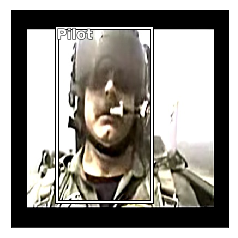

In [441]:
idx = np.random.randint(0, sample); #row = cpu_bbx_df.iloc[idx].values
bbx = cpu_bbx_df.iloc[idx].values[1:5]
f_img = cpu_df.iloc[idx].values[0] + '.jpg'
img = Image.open(PATH_TRAIN/f_img)
display_anno(img, bbx)
print(f_img)

Some of these are mislabeled, but not enough for me to care too much. I can fix that in v3. What's more concerning is what to do about the cases where the pilot isn't visible (background class). I'll find a way to treat them as background / dismiss them. I want to turn this from a 2-stage Detector-Classifier into a 1-stage End-to-End Detector.

## Architecture

In [ ]:
class ConvBlock

In [ ]:
class SSD_Head(nn.Module):
    ## TODO